# Numba implementation of greedy search

### Imports

In [2]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit, parallel_chunksize
import pandas as pd
import sortednp as snp
import doctest
from realkd.search import GreedySearch
import matplotlib.pyplot as plt

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc
from numba.typed import List
from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
import time
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint
from bitarray.util import subset
import numpy as np
import pandas as pd

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

## Create test data

As test data we generate simple binary random matrices $R \in \{0, 1\}^{m \times n}$ with a fixed proportion of 1-entries ($\alpha=0.5$) for a range of $n$ and $m$ values.

In [3]:
RNG = np.random.default_rng(seed=0)

def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)

In [4]:
# n = number of columns
# m = number of rows
ns = np.arange(50, 501, 50)
ms = np.arange(500, 1101, 200)

alpha = 0.5

d = {}
for m in ms:
    for n in ns:
        X = rand_array((m, n), alpha=alpha)
        true_weights = RNG.random(n) * 10
        y = X @ true_weights + RNG.random(m)
        y = np.sign(y - y.mean())
        dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
        dfy = pd.Series(data=y)
        d[(m, n)] = (dfX, dfy)

## Existing implementation

In [39]:
@njit
def intersect_sorted_arrays(A, B):
  """
  Returns the sorted intersection of A and B
  - Assumes A and B are sorted
  - Assumes A and B each have no duplicates
  """
  i = 0
  j = 0
  intersection = List()

  while i < len(A) and j < len(B):
      if A[i] == B[j]:
          intersection.append(A[i])
          i += 1
          j += 1
      elif A[i] < B[j]:
          i += 1
      else:
          j += 1
  return np.asarray(intersection)

from numba import int64
@njit
def intersect_sorted_array(A, B, g, h, reg, n):
    """
    Returns the sorted intersection of A and B
        ** MAY MUTATE INPUTS **
    - Assumes A and B are sorted in reverse order (i.e. [100, 34, 2])
    - Assumes A and B each have no duplicates
    """
    intersection = List.empty_list(int64)
    if not len(A) or not len(B):
        return intersection, -1000

    A_copy = A.copy()
    B_copy = List.empty_list(int64)
    for i in B:
        B_copy.append(i)
    #   B_copy = B.copy()
    g_sum = 0
    h_sum = 0

    a = A_copy.pop()
    b = B_copy.pop()
    while len(A_copy) and len(B_copy):
        if a == b:
            intersection.append(a)
            g_sum += g[a]
            h_sum += h[a]
            a = A_copy.pop()
            b = B_copy.pop()
        elif a > b:
            a = A_copy.pop()
        else:
            b = B_copy.pop()
    
    intersection.reverse()
    return intersection, -1000 if h_sum == 0 else g_sum ** 2 / h_sum


@njit
def run_greedy_search(initial_extent, n, extents, g, h, reg):
    """
    Runs the configured search.

    :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
    """
    intent = List.empty_list(int64)
    extent = List.empty_list(int64)
    for i in initial_extent:
        extent.append(i)
    value = -10
    while True:
        best_i, best_ext = None, None
        for i in range(n):
            for index in intent:
                if index == i:
                    continue
            _extent, _value = intersect_sorted_array(extent, extents[i], g, h, reg, n)
            # _value = objective_function(_extent)
            if _value > value:
                value = _value
                best_ext = _extent
                best_i = i
        if best_i is not None:
            # Found a good addition, update intent and try again
            intent.append(best_i)
            extent = best_ext
        else:
            # Intent can't get any better
            break
    return intent

class NumbaGreedySearch:
    def __init__(self, ctx, bdn, verbose=False, **kwargs):
        """

        :param Context ctx: the context defining the search space
        :param callable obj: objective function
        :param callable bnd: bounding function satisfying that ``bnd(q) >= max{obj(r) for r in successors(q)}`` (for signature compatibility only, not currently used)
        :param int verbose: level of verbosity

        """
        self.ctx = ctx
        self.verbose = verbose

    def run(self, g, h, reg, n):
        """
        Runs the configured search.

        :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
        """
        initial_extent = np.array(self.ctx.extension([]))
        n = self.ctx.n
        extents = List(self.ctx.extents)

        intent = run_greedy_search(initial_extent, self.ctx.n, extents, g, h, reg)

        return Conjunction(map(lambda i: self.ctx.attributes[i], intent))

def get_ghregn(X, y):
    """
    This would be part of the objective e.g GradientBoostingObjective
    """
    # The following is only ONE example of this class of objective function, it would be different for
    # different X, y, losses, regs and predictions.
    loss = logistic_loss
    reg = 1.0
    predictions = zeros_like(y)
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return g, h, reg, n, objective_function

In [40]:
def run_search_numba(data, context):
    ctx, g, h, reg, n, obj_fn = context
    search = NumbaGreedySearch(ctx=ctx, bdn=None)
    search.run(g, h, reg, n)

def run_search_base(data, context):
    ctx, g, h, reg, n, obj_fn = context
    search = GreedySearch(ctx=ctx, obj=obj_fn, bdn=None)
    search.run()

In [42]:
t_numba = {}
t_base = {}

ms_to_plot = ms
ns_to_plot = ns

pre_made_ctx = {}

for m in ms_to_plot:
    data = d[(m, ns[0])]
    ctx = Context.from_df(data[0])
    g, h, reg, n2, obj_fn = get_ghregn(data[0], data[1])
    pre_made_ctx[(m, ns[0])] = ctx, g, h, reg, n2, obj_fn

for n in ns_to_plot:
    data = d[(ms[0], n)]
    ctx = Context.from_df(data[0])
    g, h, reg, n2, obj_fn = get_ghregn(data[0], data[1])
    pre_made_ctx[(ms[0], n)] = ctx, g, h, reg, n2, obj_fn


# Dry runs to compile numba code
run_search_numba(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])
run_search_base(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])

for m in ms_to_plot:
    t_numba[(m, ns[0])] = %timeit -o run_search_numba(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])
    t_base[(m, ns[0])] = %timeit -o run_search_base(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])

for n in ns_to_plot:
    t_numba[(ms[0], n)] = %timeit -o run_search_numba(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])
    t_base[(ms[0], n)] = %timeit -o run_search_base(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])

24 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.96 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.2 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.96 ms ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.5 ms ± 58 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.5 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.7 ms ± 99 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.96 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.1 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.92 ms ± 9.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.6 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.87 ms ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
35.8 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.5 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
62 ms ± 154 

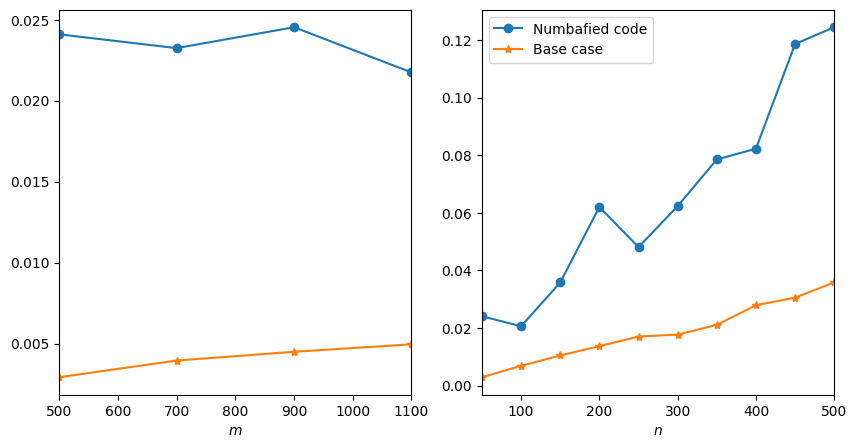

In [43]:
plt.subplots(1, 2, figsize=(10, 5))

t_numba_mean = [t_numba[(m, ns[0])].average for m in ms_to_plot]
t_numba_std = [t_numba[(m, ns[0])].stdev for m in ms_to_plot]
t_base_mean = [t_base[(m, ns[0])].average for m in ms_to_plot]
t_base_std = [t_base[(m, ns[0])].stdev for m in ms_to_plot]

plt.subplot(1, 2, 1)
plt.plot(ms_to_plot, t_numba_mean, marker='o')
plt.plot(ms_to_plot, t_base_mean, marker='*')
plt.xlim(ms_to_plot[0], ms_to_plot[-1])
plt.xlabel('$m$')

t_numba_mean = [t_numba[(ms[0], n)].average for n in ns_to_plot]
t_numba_std = [t_numba[(ms[0], n)].stdev for n in ns_to_plot]
t_base_mean = [t_base[(ms[0], n)].average for n in ns_to_plot]
t_base_std = [t_base[(ms[0], n)].stdev for n in ns_to_plot]

plt.subplot(1, 2, 2)
plt.plot(ns_to_plot, t_numba_mean, marker='o', label='Numbafied code')
plt.plot(ns_to_plot, t_base_mean, marker='*', label='Base case')
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.xlabel('$n$')
plt.legend()

plt.show()